In [1]:
%tensorflow_version 2.x

#!pip install tf-nightly-gpu
import tensorflow as tf
print(tf.__version__)

# Test if GPU is active
device_name = tf.test.gpu_device_name()
device_name

TensorFlow 2.x selected.
2.2.0-dev20200324


''

In [2]:
# Download the dataset
!git clone https://github.com/AlessioGalluccio/GuyaDataSet

fatal: destination path 'GuyaDataSet' already exists and is not an empty directory.


In [3]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import os.path
from os import path

SEED = 42

train_path = '/content/GuyaDataSet/training'
validation_path = '/content/GuyaDataSet/validation'

bs = 16
image_size = 224
num_class = len(listdir(train_path))
 
lista = listdir(train_path)
lista.sort()

#Preprocessing list

## height_shift_range: Float (fraction of total height). Range for random vertical shifts.
## fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}. Points outside the boundaries of the input are filled according to the given mode:
## "constant": kkkkkkkk|abcd|kkkkkkkk (cval=k)
## "nearest":  aaaaaaaa|abcd|dddddddd
## "reflect":  abcddcba|abcd|dcbaabcd
## "wrap":  abcdabcd|abcd|abcdabcd

## width_shift_range: Float (fraction of total width). Range for random horizontal shifts.

## shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)

## zoom_range: Float or [lower, upper]. Range for random zoom. 
## If a float,  [lower, upper] = [1-zoom_range, 1+zoom_range].



train_datagen = ImageDataGenerator(rescale=1./255)#,
                                   #shear_range=0.2
                                   #zoom_range=[0.1,0.4],
                                   #height_shift_range=0.2,fill_mode="constant"
                                   #width_shift_range=0.25,
                                   #horizontal_flip=True,
                                   #vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=bs,
                        classes = lista,
                        color_mode='rgb',
                        shuffle=True,
                        class_mode='categorical',
                        seed = SEED)


#Se volessi un fixed validation set (da cartella)

validation_datagen = ImageDataGenerator(
     rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory = validation_path,
    shuffle=False,
    batch_size=bs,
    classes = lista,
    target_size=(image_size,image_size),
    color_mode = 'rgb',
    class_mode='categorical',
    seed = SEED
    )


Found 150 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_size, image_size, 3], [None, num_class]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, image_size, image_size, 3], [None, num_class]))
#valid_dataset = valid_dataset.repeat()

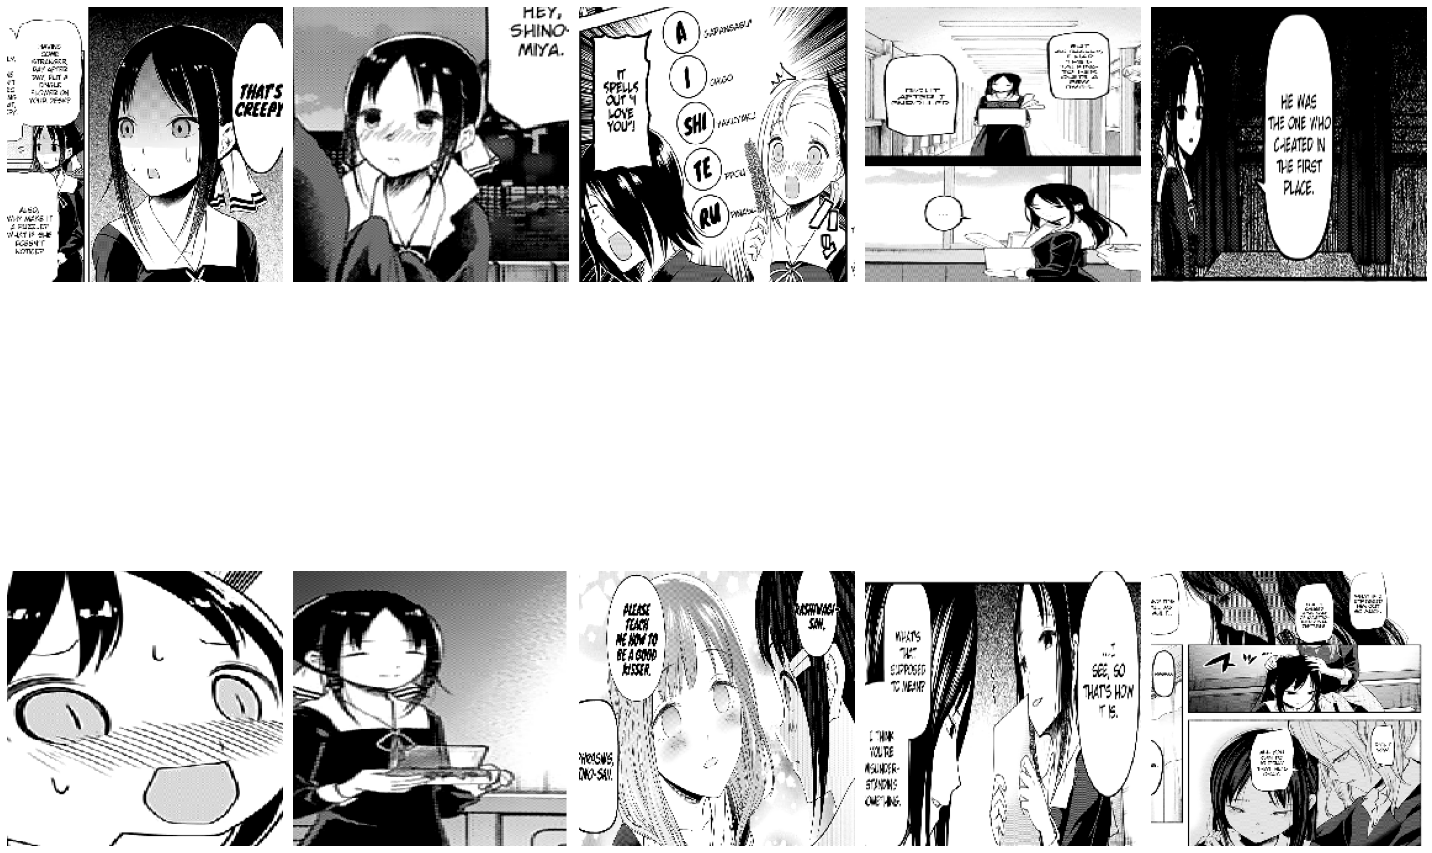

In [5]:
import matplotlib.pyplot as plt

sample_training_images, _ = next(train_generator)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:10])

In [6]:
train_generator.class_indices

{'bakaguya': 0, 'iceguya': 1, 'noguya': 2}

In [0]:
# Keras Model subclassing 
# -----------------------

# Please note that there are many ways to implement a CNN
# Here subclassing is used just for teaching purposes, but you
# can simply write every single layer as usual using Model or Sequential..

# Create convolutional block
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(filters=num_filters,
                                             kernel_size=(3, 3),
                                             strides=(1, 1), 
                                             padding='same')
        #self.activation = tf.keras.layers.ReLU()  # we can specify the activation function directly in Conv2D
        self.pooling = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        #self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, inputs):
        x = self.conv2d(inputs)
        #x = self.activation(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        return x

In [0]:
# Create Model
# ------------

depth = 5
start_f = 8
num_classes = num_class

class CNNClassifier(tf.keras.Model):
    def __init__(self, depth, start_f, num_classes):
        super(CNNClassifier, self).__init__()
        
        self.feature_extractor = tf.keras.Sequential()
    
        for i in range(depth):
            self.feature_extractor.add(ConvBlock(num_filters=start_f))
            start_f *= 2
            
        self.flatten = tf.keras.layers.Flatten()
        self.classifier = tf.keras.Sequential()
        self.classifier.add(tf.keras.layers.Dense(units=128, activation='relu'))
        self.classifier.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
        
    def call(self, inputs):
        x = self.feature_extractor(inputs)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    
# Create Model instance
model = CNNClassifier(depth=depth,
                      start_f=start_f,
                      num_classes=num_classes)
# Build Model (Required)
model.build(input_shape=(None, image_size, image_size, 3))

In [0]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [10]:
train_generator.samples

150

In [11]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

model.fit(x=train_generator,
          epochs=30,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(len(train_generator))),
          validation_data=validation_generator,
          validation_steps=int(np.ceil(len(validation_generator))),
          callbacks=callbacks)


#%load_ext tensorboard
#%tensorboard --logdir serve

#tbc=TensorBoardColab()

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/30
10/10 [==============================] - 6s 635ms/step - loss: 1.6757 - accuracy: 0.3333 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 2/30
10/10 [==============================] - 6s 600ms/step - loss: 1.1120 - accuracy: 0.3267 - val_loss: 1.1380 - val_accuracy: 0.3333
Epoch 3/30
10/10 [==============================] - 6s 599ms/step - loss: 1.0473 - accuracy: 0.4733 - val_loss: 1.0273 - val_accuracy: 0.4615
Epoch 4/30
10/10 [==============================] - 6s 600ms/step - loss: 1.0138 - accuracy: 0.5000 - val_loss: 1.2883 - val_accuracy: 0.3077
Epoch 5/30
10/10 [==============================] - 6s 600ms/step - loss: 0.9485 - accuracy: 0.6800 - val_loss: 0.9886 - val_accuracy: 0.3846
Epoch 6/30
10/10 [==============================] - 6s 600ms/step - loss: 0.7725 - accuracy: 0.7400 - val_loss: 1.0012 - val_accuracy: 0.3846
Epoch 7/30
10/10 [==============================] - 6s 601ms/step - loss: 0.6786 - accuracy: 0.7200 - val_loss: 1.3716 - val_accuracy: 0.3333
Epoch 

In [36]:
#voglio vedere le predizioni sul validation set
test_datagen = ImageDataGenerator(rescale=1./255)



test_generator = test_datagen.flow_from_directory(directory='/content/GuyaDataSet/validation',
                              # only read images from `test` directory
                              # don't generate labels
                              classes=['noguya'],
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              # use same size as in training
                              target_size=(image_size, image_size))


pred = model.predict(x=test_generator,
              callbacks = callbacks,
              steps = len(test_generator),
              verbose = 1)
softmax = pred.argmax(axis=-1)
softmax
#test_generator.filenames

Found 13 images belonging to 1 classes.
1/1 [==============================] - 0s 1ms/step


array([2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2])

In [32]:
pred

array([[0.00887028, 0.01852008, 0.9726096 ],
       [0.09589774, 0.05559376, 0.84850854],
       [0.9889115 , 0.00339449, 0.00769406],
       [0.01821799, 0.02060823, 0.96117383],
       [0.08554733, 0.68937176, 0.22508086],
       [0.1655134 , 0.68078125, 0.15370543],
       [0.06078791, 0.00623259, 0.93297946],
       [0.8042863 , 0.06690162, 0.12881209],
       [0.41585648, 0.10936058, 0.4747829 ],
       [0.83726716, 0.0580407 , 0.10469218],
       [0.7943548 , 0.18488482, 0.02076042],
       [0.00366997, 0.07624194, 0.9200881 ],
       [0.06794976, 0.05653796, 0.8755123 ]], dtype=float32)